# **Roya** **Ghamari** **- 2071969**

# **Date: 31/01/2024**

# Inroduction to Deep Belief Network

Deep Belief Networks (DBNs) are a type of artificial neural network architecture that consists of multiple layers of stochastic, latent variables. A key feature of DBNs is their hierarchical structure, which is typically formed by stacking multiple layers of Restricted Boltzmann Machines (RBMs). Restricted Boltzmann Machines (RBMs) are generative stochastic neural networks with a visible layer and a hidden layer, featuring symmetric connections between them. Trained through unsupervised learning, RBMs use contrastive divergence to learn hierarchical representations of data, commonly employed in pre-training deep neural networks. Deep Belief Networks (DBNs), on the other hand, leverage a stack of RBMs to form a multi-layered, hierarchical structure. In the initial unsupervised pre-training phase, each layer undergoes RBM training, followed by a supervised fine-tuning phase. DBNs were pivotal in the early stages of deep learning, aiding in weight initialization and facilitating the training of deep architectures. While their significance has somewhat diminished with the rise of other deep learning techniques, RBMs and DBNs continue to contribute to the broader landscape of artificial neural networks.

# Preparation

In [1]:

def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}


In [2]:
%%capture
get_dbn_library()

Here we import the necessary libraries:

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torch.nn as nn
import torchvision as tv
import torch.nn.functional as functional
from DBN import DBN
from tqdm.notebook import tqdm
from numpy.ma.core import size
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random



Now we choose the type of computing device to be employed, whether it be a Central Processing Unit (CPU) or Graphics Processing Unit (GPU)

In [4]:
print(torch.cuda.is_available()) #we want to see if cuda is available or not
if torch.cuda.is_available():
    selected_device = torch.device("cuda")
else:
    selected_device = torch.device("cpu")
print(selected_device)

True
cuda


# Dataset

The dataset used in this project is Fashion-MNIST. Fashion-MNIST, created by Zalando, consists of a training set with 60,000 examples and a test set with 10,000 examples. Each example is a grayscale image of dimensions 28x28 pixels and is labeled with one of 10 classes.

The images in dataset are 28 pixels in height and 28 pixels in width, resulting in 784 pixels per image. Each pixel is represented by a single pixel-value, indicating the lightness or darkness on a scale from 0 to 255. The datasets consist of 785 columns, with the first column representing the class label of the associated article of clothing. The remaining columns contain pixel-values corresponding to the image. The dataset's labels range from 0 to 9, representing different types of clothing, such as T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot. First we import the dataset:

In [5]:
%%capture
transform_train = tv.transforms.Compose([tv.transforms.ToTensor()])
FMNIST_train = tv.datasets.FashionMNIST('data/', train=True, download=True, transform=transform_train)

transform_test = tv.transforms.Compose([tv.transforms.ToTensor()])
FMNIST_test = tv.datasets.FashionMNIST("data/", train=False, download=True, transform=transform_test)


In [6]:
FMNIST_train.data = FMNIST_train.data/255
FMNIST_test.data = FMNIST_test.data/255

In [7]:
Xtrain = np.array(FMNIST_train.data)
Xtest = np.array(FMNIST_test.data)
ytrain = np.array(FMNIST_train.targets)
ytest = np.array(FMNIST_test.targets)

Xtrain_shape = Xtrain.shape
ytrain_values = ytrain
Xtest_shape = Xtest.shape
ytest_values = ytest

print(Xtrain_shape, ytrain_values, Xtest_shape, ytest_values)

(60000, 28, 28) [9 0 0 ... 3 0 5] (10000, 28, 28) [9 2 1 ... 8 1 5]


Now we assign numbers to the labels:

In [8]:
labeldict = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}


# Visualizing the data


Let's now visualizes a random sample from both the training and testing datasets.

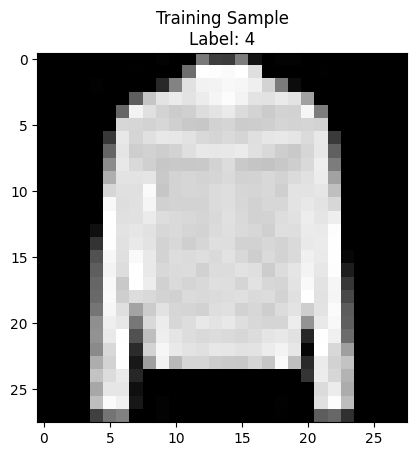

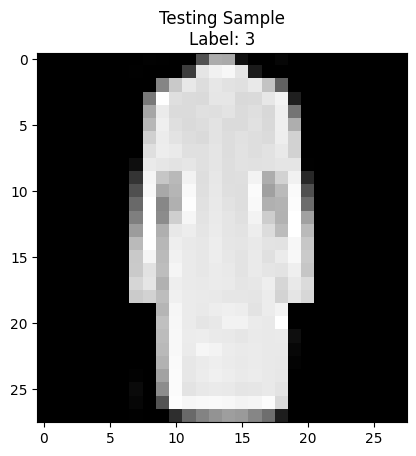

In [9]:

# Function to visualize a random sample from the dataset
def visualize_sample(X, y, dataset_type="Training"):
    random_index = np.random.randint(0, len(X))
    image = X[random_index]
    label = y[random_index]

    plt.imshow(image, cmap='gray')
    plt.title(f"{dataset_type} Sample\nLabel: {label}")
    plt.show()

# Visualizing a random sample from the training dataset
visualize_sample(Xtrain, ytrain, dataset_type="Training")

# Visualizing a random sample from the testing dataset
visualize_sample(Xtest, ytest, dataset_type="Testing")


Or also we can display a grid of random images from the dataset along with their corresponding labels.

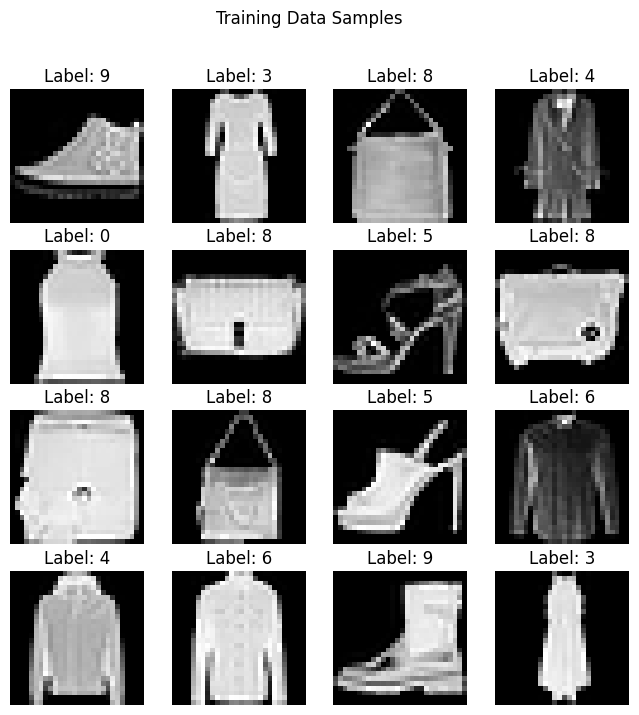

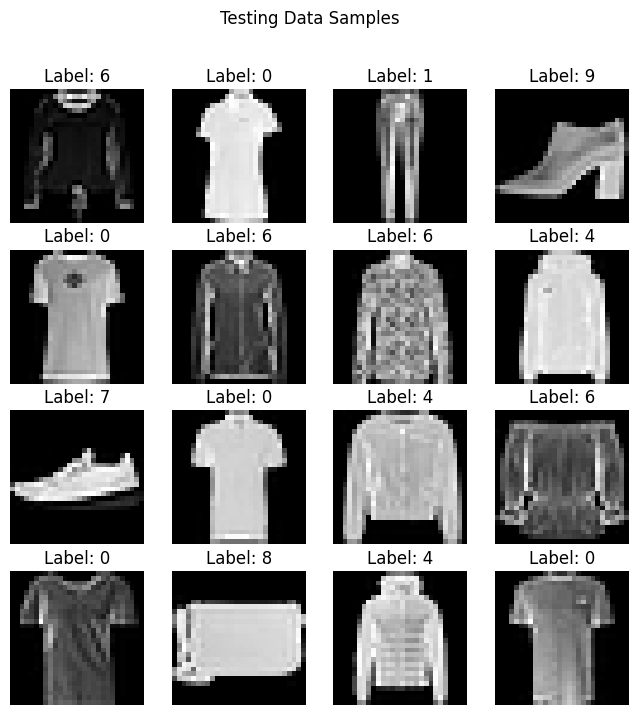

In [10]:
def visualize_data_samples(X, y, dataset_type="Training", num_samples=16):
    plt.figure(figsize=(8, 8))
    random_indices = random.sample(range(len(X)), num_samples)

    for i, index in enumerate(random_indices, 1):
        plt.subplot(4, 4, i)
        plt.imshow(X[index], cmap='gray')
        plt.title(f"Label: {y[index]}")
        plt.axis('off')

    plt.suptitle(f"{dataset_type} Data Samples")
    plt.show()

# Visualize a grid of random samples from the training dataset
visualize_data_samples(Xtrain, ytrain, dataset_type="Training")

# Visualize a grid of random samples from the testing dataset
visualize_data_samples(Xtest, ytest, dataset_type="Testing")


#Deep Belief Network




A Deep Belief Network (DBN) training process involves pre-training and fine-tuning:

1. **Initialize Structure:** Creates a network with input, hidden, and output layers.

2. **Pre-training (Layer-wise):** Trains each layer separately using unsupervised learning, often with Restricted Boltzmann Machines (RBMs). RBMs help the network learn hierarchical features.

3. **Fine-tuning (Backpropagation):** Fine-tune the entire network using backpropagation and labeled data.The weights get updated to minimize the error between predicted and actual outputs.

4. **Training Iterations:** Iterates the pre-training and fine-tuning steps to improve network performance.

5. **Output:** Uses the trained network for tasks like classification or feature extraction.

In [11]:
FMNIST_train.data = torch.from_numpy(Xtrain.reshape(60000, 28, 28))
FMNIST_test.data = torch.from_numpy(Xtest.reshape(10000, 28, 28))
FMNIST_train.targets = torch.from_numpy(ytrain)
FMNIST_test.targets = torch.from_numpy(ytest)


 Now we initialize a Deep Belief Network (DBN) for the Fashion-MNIST dataset with specific parameters:

In [12]:
dbn_FMNIST = DBN(
    visible_units=28*28,
    hidden_units=[300, 300, 700],
    k=1,
    learning_rate=0.1,
    learning_rate_decay=False,
    initial_momentum=0.5,
    final_momentum=0.95,
    weight_decay=0.0001,
    xavier_init=False,
    increase_to_cd_k=False,
    use_gpu=torch.cuda.is_available()
)


In [13]:
epochs = 50
batch_size =128

dbn_FMNIST.train_static(
    FMNIST_train.data,
    FMNIST_train.targets,
    epochs,
    batch_size
)


--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.9590     |0.0892       |280.7017   |5.8926     |
|20    |1.8318     |0.0834       |258.9809   |4.5800     |
|30    |1.8052     |0.0828       |256.3856   |5.1234     |
|40    |1.7965     |0.0802       |255.3620   |5.2399     |
|50    |1.7917     |0.0820       |252.0779   |4.4153     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4216     |0.0501       |99.3915   |2.2708     |
|20    |1.3195     |0.0450       |92.4344   |1.9168     |
|30    |1.2924     |0.0430       |90.2586   |1.8553     |
|40    |1.2803     |0.0431       |88.8079   |1.8475     |
|50    |1.2728     |0.0439       |88.4236   |1.9339     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2983     |0.0432       |117.2387   |2.2114     |
|20    |1.1476     |0.0372       |103.9817   |1.9092    



#learned weights:

Now we focuse on analyzing and visualizing the learned weights from the first layer of the trained DBN. It defines functions to extract weights from the DBN, apply a threshold to the weights, plot receptive fields using the weights, and perform min-max scaling on the weights. The weights from the first layer are obtained, a threshold is applied to filter out smaller weights, and then the weights are scaled using min-max scaling. Finally, the receptive fields corresponding to the learned weights are plotted using a grid of images. This analysis provides insights into the features learned by the first layer of the DBN, helping to interpret and understand the representations captured during the training process.

In [14]:
from sklearn.preprocessing import MinMaxScaler
def get_weights_from_dbn(dbn, layer_index):
    return dbn.rbm_layers[layer_index].W.cpu().numpy()

def apply_threshold_to_weights(weights, threshold=0):
    return weights * (abs(weights) > threshold)

def plot_layer_receptive_fields(weights):
    num_subplots = 100
    n_rows_cols = int(math.sqrt(num_subplots))
    fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))

    for i in range(num_subplots):
        row = i % n_rows_cols
        col = i // n_rows_cols
        axes[row, col].imshow(weights[i, :].reshape((28, 28)), cmap=plt.cm.gray)

def apply_min_max_scaling(learned_weights):
    original_shape = learned_weights.shape
    min_max_scaler = MinMaxScaler()
    flattened_weights = learned_weights.ravel().reshape(-1, 1)
    min_max_scaled_weights = min_max_scaler.fit_transform(flattened_weights)
    min_max_scaled_weights = min_max_scaled_weights.reshape(original_shape)
    return min_max_scaled_weights

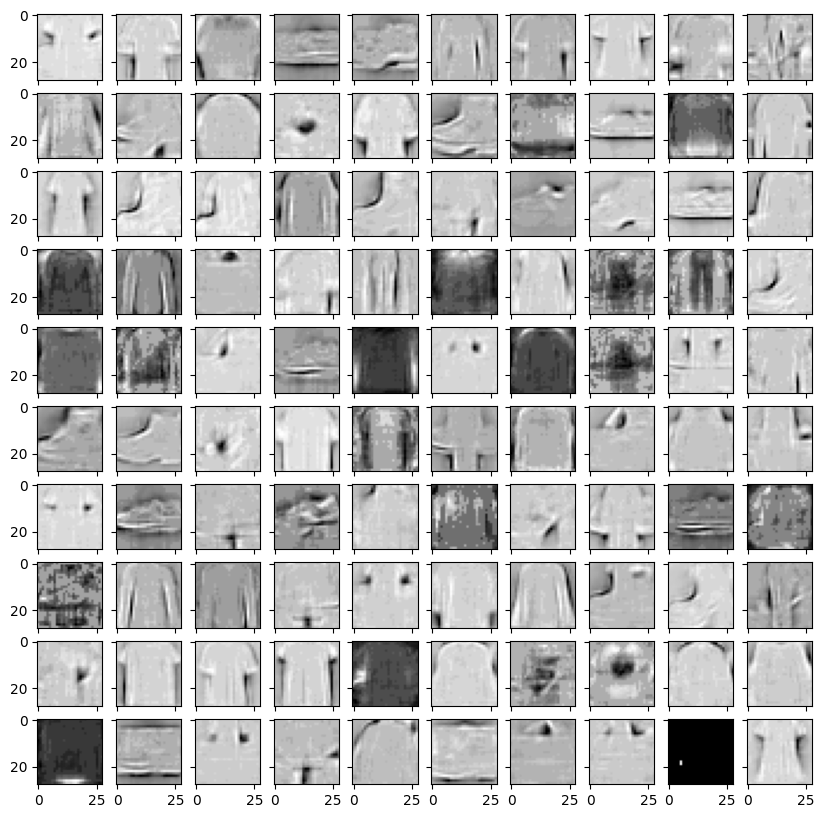

In [15]:
learned_weights_layer_1 = get_weights_from_dbn(dbn_FMNIST, layer_index=0)
learned_weights_layer_1 = apply_threshold_to_weights(learned_weights_layer_1, 0.1)
learned_weights_layer_1 = apply_min_max_scaling(learned_weights_layer_1)

plot_layer_receptive_fields(learned_weights_layer_1.T)


Now we visualize the interactions between the learned weights from the first and second layers:

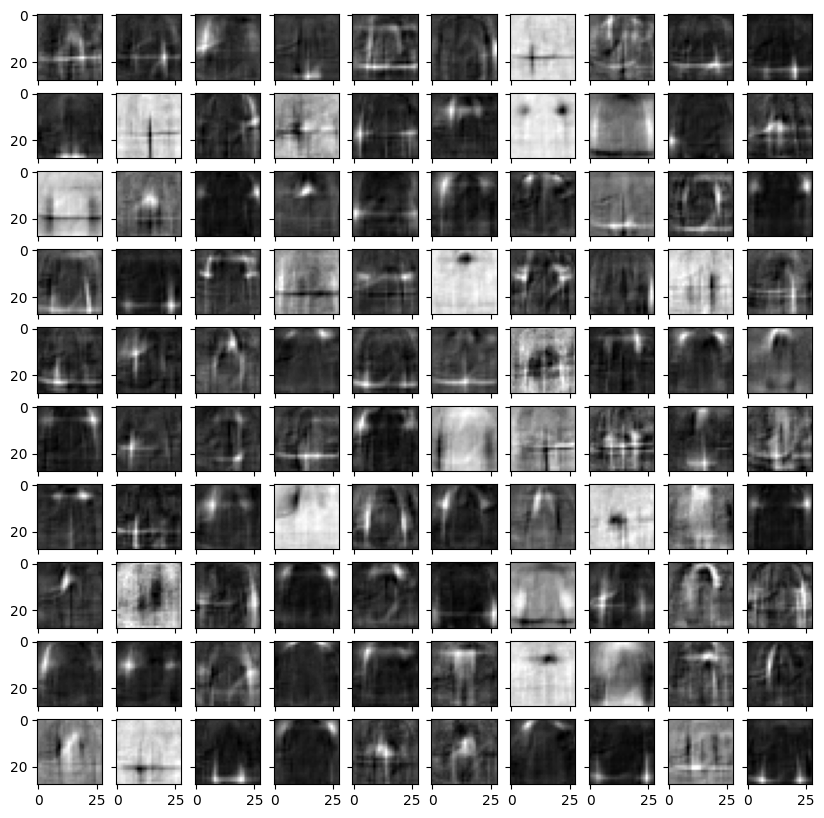

In [16]:
learned_weights_layer_1 = get_weights_from_dbn(dbn_FMNIST, layer_index=0)
learned_weights_layer_2 = get_weights_from_dbn(dbn_FMNIST, layer_index=1)

learned_weights_layer_1 = apply_threshold_to_weights(learned_weights_layer_1, 0.1)
learned_weights_layer_2 = apply_threshold_to_weights(learned_weights_layer_2, 0.1)

learned_weights_product = learned_weights_layer_1 @ learned_weights_layer_2
learned_weights_product = apply_threshold_to_weights(learned_weights_product, 0.1)
learned_weights_product = apply_min_max_scaling(learned_weights_product)

plot_layer_receptive_fields(learned_weights_product.T)

The following code extracts the hidden representations from the specified layer (k). It then applies this function successively to obtain the hidden representations of the first three layers (k=0, k=1, k=2). The resulting hidden representations are printed, indicating the shape of the hidden representation from the first layer

In [32]:
def kth_layer_repr(input_data, k, device):
    flat_input = input_data.view((input_data.shape[0], -1)).to(torch.float32).to(selected_device)
    hidden_repr = dbn_FMNIST.rbm_layers[k].to_hidden(flat_input)[0].to(selected_device)
    return hidden_repr

In [33]:
repr_layer_1 = kth_layer_repr(FMNIST_train.data, k=0, device=selected_device)
repr_layer_2 = kth_layer_repr(repr_layer_1, k=1, device=selected_device)
repr_layer_3 = kth_layer_repr(repr_layer_2, k=2, device=selected_device)
print(repr_layer_1.shape)

torch.Size([60000, 300])


# Linear readout
Linear readout serves as a method within neural networks to generate output by linearly combining the activations of neurons in the final layer. This approach finds application in various scenarios, notably in Recurrent Neural Networks (RNNs), offering advantages like simplicity, efficiency, interpretability, and scalability.

In the domain of Deep Belief Networks (DBNs), each layer progressively learns abstract representations of input data. Exploiting activations from each layer as features, the linear readout taps into the hierarchical representation embedded in the network, amalgamating both low-level and high-level features for predictive tasks. For training the linear readout, supervised learning is applied to a labeled dataset, tuning weights to minimize the disparity between predicted and true outputs. The core objective is to deploy the DBN's computed representations for specific predictions, leveraging the hierarchical structure to boost classifier performance.

In the provided code linear model is defined for each layer in the DBN through the LinearModel class. The core aim is to create instances of the linear model for the three layers of the DBN.

In [34]:
import torch.nn as nn
class LinearModel(nn.Module):
    def __init__(self, last_layer_size):
        super().__init__()
        self.linear = nn.Linear(last_layer_size, 10)

    def forward(self, x):
        return self.linear(x)

In [35]:
layer_size_0 = dbn_FMNIST.rbm_layers[0].W.shape[1]
layer_size_1 = dbn_FMNIST.rbm_layers[1].W.shape[1]
layer_size_2 = dbn_FMNIST.rbm_layers[2].W.shape[1]

# Create LinearModel instances for each layer
linear1 = LinearModel(layer_size_0).to(selected_device)
linear2 = LinearModel(layer_size_1).to(selected_device)
linear3 = LinearModel(layer_size_2).to(selected_device)

Now we define a function to train linear models using stochastic gradient descent (SGD) for a specified number of epochs. The core aim is to optimize the parameters of the linear models based on the provided input data and corresponding targets from the Fashion MNIST training set. The cross-entropy loss is used as the objective function for optimization.

In [36]:
def train_neural_network(network, input_data, epochs=1500):
    optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        optimizer.zero_grad()
        predictions = network(input_data).squeeze()
        targets = FMNIST_train.targets.reshape(predictions.shape[0]).to(selected_device)
        loss = loss_fn(predictions, targets)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print("Epoch: {:3d}/{}, Loss: {:.4f}".format(epoch + 1, epochs, loss))

# Example usage:
train_neural_network(linear1, repr_layer_1, epochs=1500)
train_neural_network(linear2, repr_layer_2, epochs=1500)
train_neural_network(linear3, repr_layer_3, epochs=1500)

Epoch:   1/1500, Loss: 2.3914
Epoch: 101/1500, Loss: 1.7187
Epoch: 201/1500, Loss: 1.3469
Epoch: 301/1500, Loss: 1.1402
Epoch: 401/1500, Loss: 1.0119
Epoch: 501/1500, Loss: 0.9254
Epoch: 601/1500, Loss: 0.8635
Epoch: 701/1500, Loss: 0.8169
Epoch: 801/1500, Loss: 0.7805
Epoch: 901/1500, Loss: 0.7511
Epoch: 1001/1500, Loss: 0.7267
Epoch: 1101/1500, Loss: 0.7062
Epoch: 1201/1500, Loss: 0.6885
Epoch: 1301/1500, Loss: 0.6732
Epoch: 1401/1500, Loss: 0.6596
Epoch:   1/1500, Loss: 2.2933
Epoch: 101/1500, Loss: 1.4900
Epoch: 201/1500, Loss: 1.1327
Epoch: 301/1500, Loss: 0.9639
Epoch: 401/1500, Loss: 0.8672
Epoch: 501/1500, Loss: 0.8043
Epoch: 601/1500, Loss: 0.7597
Epoch: 701/1500, Loss: 0.7261
Epoch: 801/1500, Loss: 0.6996
Epoch: 901/1500, Loss: 0.6780
Epoch: 1001/1500, Loss: 0.6600
Epoch: 1101/1500, Loss: 0.6445
Epoch: 1201/1500, Loss: 0.6311
Epoch: 1301/1500, Loss: 0.6194
Epoch: 1401/1500, Loss: 0.6089
Epoch:   1/1500, Loss: 2.3289
Epoch: 101/1500, Loss: 1.6084
Epoch: 201/1500, Loss: 1.2406


The provided code calculates and prints the accuracy of the linear models. It does so by obtaining the hidden representations of the test data using the kth_layer_repr function. Finally, a function is used to compute the accuracy of each linear model's predictions compared to the true labels in the test set.

In [37]:
repr_layer_1_test = kth_layer_repr(FMNIST_test.data, k=0, device=selected_device)
repr_layer_2_test = kth_layer_repr(repr_layer_1_test, k=1, device=selected_device)
repr_layer_3_test = kth_layer_repr(repr_layer_2_test, k=2, device=selected_device)


In [38]:
pred_test1 = linear1(repr_layer_1_test)
pred_test2 = linear2(repr_layer_2_test)
pred_test3 = linear3(repr_layer_3_test)

In [39]:
def compute_acc(pred_test, targets):
    pred_indices = pred_test.max(axis=1).indices  # Convert probabilities to indices
    accuracy = (pred_indices == targets).sum() / len(targets)
    return accuracy.item()

In [40]:
compute_acc(pred_test1, FMNIST_test.targets.to(selected_device))

0.7901999950408936

In [41]:
compute_acc(pred_test2, FMNIST_test.targets.to(selected_device))

0.7972999811172485

In [42]:
compute_acc(pred_test3, FMNIST_test.targets.to(selected_device))

0.7976999878883362

#FEED-FORWARD Model


A feedforward neural network, also known as a multilayer perceptron (MLP), is a type of artificial neural network designed for information to flow in one direction: from the input layer, through the hidden layers, and finally to the output layer. Unlike recurrent neural networks, there are no feedback loops in a feedforward model. Each layer in the network processes the input data, transforming it through weighted connections and applying activation functions to capture complex patterns in the data. The architecture includes an input layer that receives features, one or more hidden layers that progressively learn hierarchical representations, and an output layer that produces the final predictions. Training involves adjusting the weights and biases to minimize the difference between predicted and actual outputs, typically using techniques like backpropagation and gradient descent. Feedforward models are widely used for various tasks, including classification, regression, and pattern recognition.
In code below, a feedforward neural network is defined with three hidden layers and an output layer for classifying Fashion MNIST images. The network is trained using the train_neural_network function. The forward pass involves passing the input through each hidden layer with ReLU activation functions, and the output layer produces predictions. The model is then evaluated on the test set.

In [43]:
class Feedforward(nn.Module):
    def __init__(self, h1_size, h2_size, h3_size):
        super().__init__()
        self.h1 = nn.Linear(784, h1_size)
        self.h2 = nn.Linear(h1_size, h2_size)
        self.h3 = nn.Linear(h2_size, h3_size)
        self.out = nn.Linear(h3_size, 10)

    def forward(self, input_data):
        relu = nn.ReLU()
        h1_repr = relu(self.h1(input_data))
        h2_repr = relu(self.h2(h1_repr))
        h3_repr = relu(self.h3(h2_repr))
        output = self.out(h3_repr)
        return output



In [54]:
ffnn = Feedforward(200, 200, 400).to(selected_device)


In [55]:
train_neural_network(ffnn, FMNIST_train.data.reshape((60000, 784)).to(selected_device), epochs=1500)
predictions_ffnn = ffnn(FMNIST_test.data.reshape((10000, 784)).to(selected_device))

Epoch:   1/1500, Loss: 2.3038
Epoch: 101/1500, Loss: 2.2810
Epoch: 201/1500, Loss: 2.2469
Epoch: 301/1500, Loss: 2.1750
Epoch: 401/1500, Loss: 1.9931
Epoch: 501/1500, Loss: 1.6329
Epoch: 601/1500, Loss: 1.3218
Epoch: 701/1500, Loss: 1.1392
Epoch: 801/1500, Loss: 1.0262
Epoch: 901/1500, Loss: 0.9497
Epoch: 1001/1500, Loss: 0.8923
Epoch: 1101/1500, Loss: 0.8460
Epoch: 1201/1500, Loss: 0.8078
Epoch: 1301/1500, Loss: 0.7761
Epoch: 1401/1500, Loss: 0.7496


In [56]:
compute_acc(predictions_ffnn, FMNIST_test.targets.to(selected_device))


0.722599983215332

#Psychometric Curves


The provided code introduces Gaussian noise to the Fashion MNIST test data as part of an experiment to assess the robustness of a model, particularly a feedforward neural network (FFNN), to noisy input data. The purpose is to evaluate how well the FFNN performs when faced with inputs containing varying levels of Gaussian noise.

The injected noise follows a Gaussian distribution with a mean of 0 and a standard deviation of 1. This simulates a realistic scenario where the input data may be corrupted by random noise. The resulting noisy test data is then used for testing the FFNN's performance under noisy conditions.

The experiment aims to gauge the robustness of the FFNN by evaluating its ability to generate accurate predictions despite the presence of Gaussian noise in the input data. The noisy test data can be used to compare the model's performance under noisy conditions against its performance on clean data, providing insights into the model's resilience and generalization capabilities.

In [57]:
def inject_noise(FMNIST_data, noise_level):
    noisy_data = FMNIST_data + noise_level * torch.randn_like(FMNIST_data)
    return(noisy_data.to(selected_device))

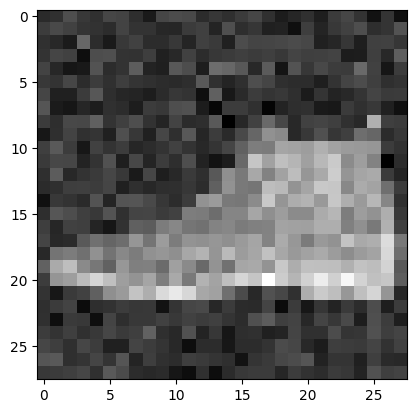

In [58]:
Fashion_test_with_noise = inject_noise(FMNIST_test.data, noise_level=0.1)
# Display the first image from the noisy test data
_ = plt.imshow(Fashion_test_with_noise[0].reshape(28, 28).to("cpu"), cmap="gray")

The code evaluates the accuracy of different layers in a Deep Belief Network (DBN) and a Feedforward Neural Network (FFNN) when tested on Fashion MNIST images with Gaussian noise. It generates noisy test data, computes DBN representations, applies previously trained read-out classifiers, and evaluates the FFNN. The accuracies of each layer in the DBN and the FFNN are then printed. This analysis assesses how well the models perform under varying levels of input noise.

In [66]:
def get_accuracy_at_noise_level(noise_level):
    # Create noisy test images
    fashion_test_with_noise = inject_noise(FMNIST_test.data, noise_level)

    # Compute DBN representations
    repr_layer_1_noisy = kth_layer_repr(fashion_test_with_noise, k=0, device=selected_device)
    repr_layer_2_noisy = kth_layer_repr(repr_layer_1_noisy, k=1, device=selected_device)
    repr_layer_3_noisy = kth_layer_repr(repr_layer_2_noisy, k=2, device=selected_device)

    # Use previously-trained read-out classifiers
    pred_first_hidden_noisy = linear1(repr_layer_1_noisy.view(repr_layer_1_noisy.size(0), -1))  # Adjust input size
    pred_second_hidden_noisy = linear2(repr_layer_2_noisy)
    pred_third_hidden_noisy = linear3(repr_layer_3_noisy)

    acc_first_hidden = compute_acc(pred_first_hidden_noisy, FMNIST_test.targets.to(selected_device))
    acc_second_hidden = compute_acc(pred_second_hidden_noisy, FMNIST_test.targets.to(selected_device))
    acc_third_hidden = compute_acc(pred_third_hidden_noisy, FMNIST_test.targets.to(selected_device))

    pred_ffnn_noisy_data = ffnn(fashion_test_with_noise.view(fashion_test_with_noise.size(0), -1))  # Adjust input size
    acc_ffnn = compute_acc(pred_ffnn_noisy_data, FMNIST_test.targets.to(selected_device))

    return acc_first_hidden, acc_second_hidden, acc_third_hidden, acc_ffnn



In [67]:
accuracy_values = get_accuracy_at_noise_level(0.3)

print("Accuracy of H1 read-out: {:.3f}".format(accuracy_values[0]))
print("Accuracy of H2 read-out: {:.3f}".format(accuracy_values[1]))
print("Accuracy of H3 read-out: {:.3f}".format(accuracy_values[2]))
print("Accuracy of FF network: {:.3f}".format(accuracy_values[3]))


Accuracy of H1 read-out: 0.772
Accuracy of H2 read-out: 0.782
Accuracy of H3 read-out: 0.786
Accuracy of FF network: 0.714


The code generates robustness curves by evaluating and plotting the accuracy of different layers in a Deep Belief Network and a Feedforward Neural Network under various levels of Gaussian noise. The curves visually depict how the models' accuracy changes as the input noise level varies.

In [68]:
def plot_robustness_curves(noise_levels):
    acc_values_first_hidden, acc_values_second_hidden, acc_values_third_hidden, acc_values_ffnn = [], [], [], []

    for noise_level in noise_levels:
        acc = get_accuracy_at_noise_level(noise_level)
        acc_values_first_hidden.append(acc[0])
        acc_values_second_hidden.append(acc[1])
        acc_values_third_hidden.append(acc[2])
        acc_values_ffnn.append(acc[3])

    fig, ax = plt.subplots()
    ax.plot(range(len(noise_levels)), acc_values_first_hidden)
    ax.plot(range(len(noise_levels)), acc_values_second_hidden)
    ax.plot(range(len(noise_levels)), acc_values_third_hidden)
    ax.plot(range(len(noise_levels)), acc_values_ffnn)

    ax.set_title("Robustness to noise")
    ax.set_xlabel("Noise level (%)")
    ax.set_ylabel("Accuracy")
    plt.xticks(range(len(noise_levels)), [int(l * 100) for l in noise_levels])
    plt.legend(["First hidden", "Second hidden", "Third hidden", "FFNN"])

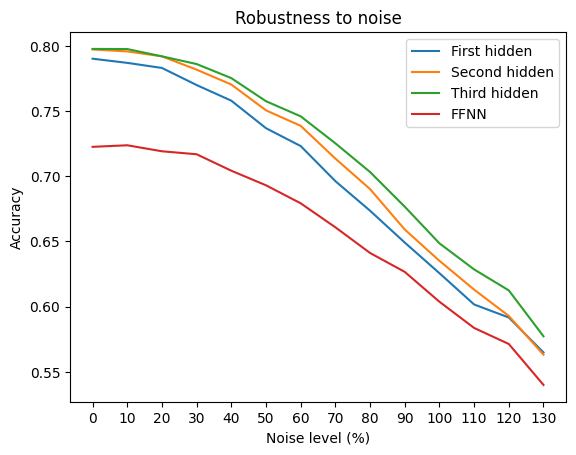

In [69]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_robustness_curves(noise_levels)

The codes below provide functions to filter and analyze hidden representations of classes in a neural network. It includes a function to filter training labels, calculate mean hidden representations for each class, concatenate these means into a matrix, and plot a dendrogram using complete linkage clustering for hierarchical representation visualization. The code applies these functions to obtain mean representation matrices for different hidden layers.

In [74]:
def mask(label):
  labels = FMNIST_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    label: hidden_representation_np[mask(label)].mean(axis=0)
    for label in range(10)
  }

def get_repr_matrix(hidden_representation):
  label_to_mean_hidd_repr = get_label_to_mean_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [76]:
#get the mean hidden representation matrix for the third hidden layer.
mean_repr_matrix_1 = get_repr_matrix(repr_layer_1)
mean_repr_matrix_2 = get_repr_matrix(repr_layer_2)
mean_repr_matrix_3 = get_repr_matrix(repr_layer_3)

In [77]:
#imports the scipy library for clustering
import scipy.cluster as cluster

#plot the dendrogram using the complete linkage clustering method
def plot_dend(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

Now we plot dendrograms for hierarchical clustering of mean hidden representations in different hidden layers. Each dendrogram represents the clustering of class representations for a specific hidden layer. The titles indicate the corresponding layer: "first hidden layer," "second hidden layer," and "third hidden layer." These visualizations offer insights into the similarity and grouping of class representations within each layer of the neural network.

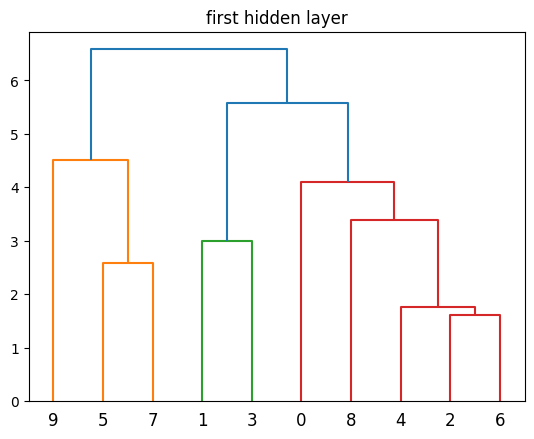

In [78]:
plot_dend(mean_repr_matrix_1, "first hidden layer")


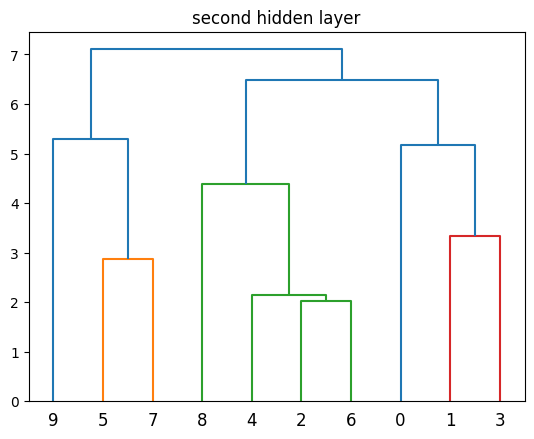

In [79]:
plot_dend(mean_repr_matrix_2, "second hidden layer")


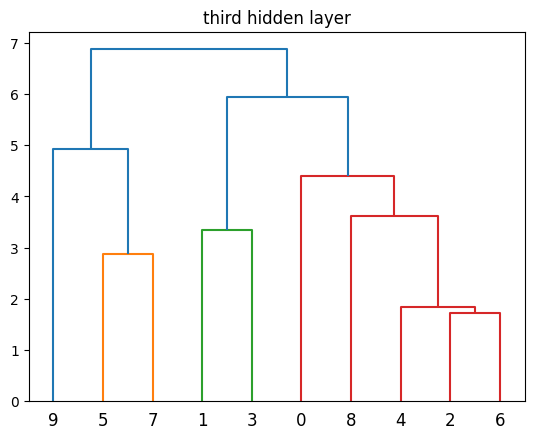

In [80]:
plot_dend(mean_repr_matrix_3, "third hidden layer")


#confusion matrix


Now we define a function for visualizing confusion matrices in a classification task. It takes true labels and predicted labels, along with other parameters, and generates a heatmap representing the comparison between predicted and true class labels. The heatmap uses color coding to convey the values in each cell, with white for higher values and black for lower values. This function provides an effective way to assess the performance of a classifier by visually examining the agreement and discrepancies between predicted and actual labels.

In [83]:
def plot_confusion_mat(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Oranges):
    if not title:
        if normalize:
            title = 'confusion matrix with normalization'
        else:
            title = 'Confusion matrix without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(15, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

classes = list(range(10))
y_true = FMNIST_test.targets.to(selected_device).cpu().numpy()


The following codes generate and display confusion matrices for three different models: a Feedforward Neural Network, the first hidden layer read-out, and the second hidden layer read-out. We visualize the agreement and discrepancies between true and predicted class labels for each model on the Fashion MNIST dataset. The resulting plots offer insights into the performance of these models across different classes.

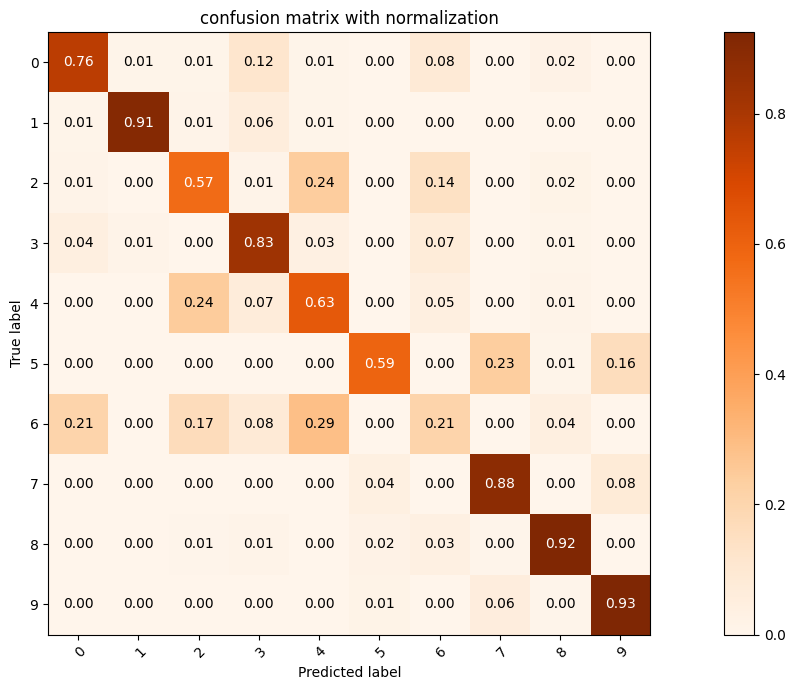

In [84]:
y_pred = predictions_ffnn.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_mat(y_true, y_pred, classes)
plt.show()

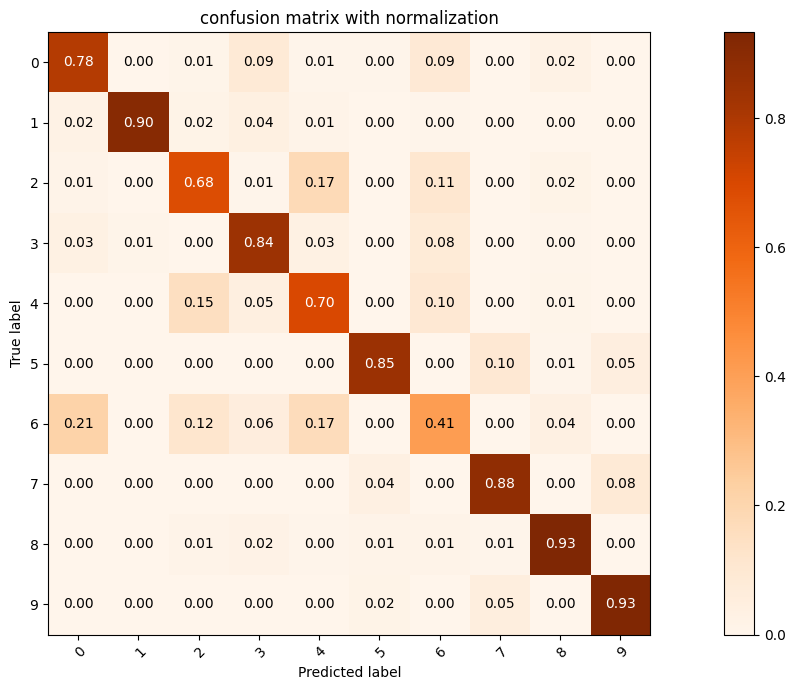

In [86]:
y_pred = pred_test1.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_mat(y_true, y_pred, classes)
plt.show()

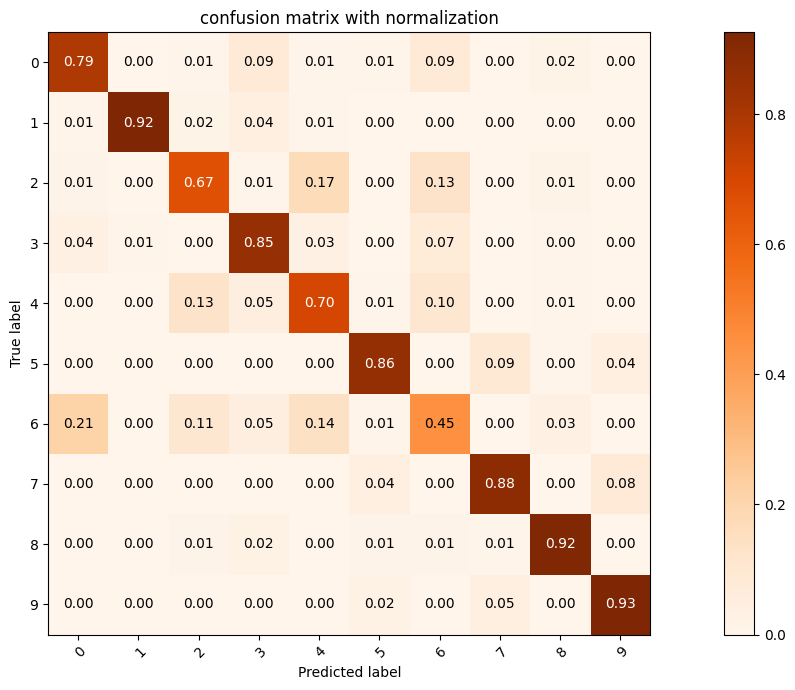

In [87]:
y_pred = pred_test2.cpu().detach().max(axis=1).indices.numpy()
plot_confusion_mat(y_true, y_pred, classes)
plt.show()

# Image attacking


An evasion attack involves manipulating the inputs to a model to induce incorrect predictions. The attacker aims to exploit vulnerabilities in the model's decision boundaries by introducing subtle perturbations to the input data. The objective is to deceive the model into making mistakes, potentially causing misclassifications or increasing confidence in incorrect predictions. Defending against evasion attacks typically involves enhancing the model's robustness through techniques like adversarial training or incorporating defenses to mitigate the impact of adversarial perturbations.

The provided code simulates an evasion attack on a Feedforward Neural Network model. It selects an image from the Fashion MNIST test dataset, makes a prediction with the model, and then introduces random confusion to the input image. The goal of this attack is to manipulate the model's predictions by inducing incorrect results or increasing confidence in an incorrect prediction. The code allows for the analysis of the impact of the evasion attack on the model's behavior.

In [128]:
attack_model = ffnn
index = 6
epsilon = 0.5
input_image = FMNIST_test.data[index].view(1, -1).to(selected_device)
original_image = input_image.reshape((28, 28))
prediction = attack_model(input_image).cpu().detach().max(axis=1).indices.numpy()[0]
true_label = FMNIST_test.targets[index].numpy()
confusion = torch.rand_like(input_image) * 2 * epsilon - epsilon
confused_image = input_image + confusion
confused_image = torch.clip(confused_image, 0, 1).cpu().numpy()



A function is defined which aims to generate adversarial examples for testing the robustness of the model. Adversarial examples are crafted by introducing small, imperceptible perturbations to the original input image. The function computes the element-wise sign of the gradient of the model's loss with respect to the input image and adjusts each pixel of the original image in the direction of this sign. The magnitude of the perturbation is controlled by the epsilon parameter, and the resulting perturbed image is clipped to ensure pixel values remain within a valid range. The goal is to evaluate how well the model withstands adversarial attacks and to identify potential vulnerabilities in its decision boundaries.

In [129]:
def Fast_Gradient_Sign_Method(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()

    confused_image = image + epsilon*sign_data_grad

    confused_image = torch.clamp(confused_image, 0, 1)

    return confused_image

The below codes define a class that combines a Deep Belief Network with readout layers for Fashion MNIST classification. It ensures gradients are required for DBN training. The forward method iteratively processes the input through DBN layers, storing hidden states. The instance is created by specifying a DBN, a list of readout layers, and a specific readout level. This class facilitates joint training and classification on Fashion MNIST images.

In [130]:
class DBNReadOut(torch.nn.Module):
    def __init__(self, dbn_mnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_mnist = dbn_mnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_mnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      p_v = image
      hidden_states = []
      for rbm in self.dbn_mnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [131]:
layer_size = dbn_FMNIST.rbm_layers[0].W.shape[1]

layer_size = dbn_FMNIST.rbm_layers[1].W.shape[1]

layer_size = dbn_FMNIST.rbm_layers[2].W.shape[1]

In [132]:
dbn_with_readout = DBNReadOut(dbn_FMNIST, [linear1, linear2, linear3], readout_level=2).float()

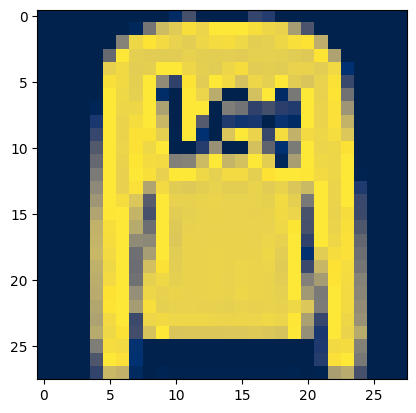

In [133]:
test_sample_idx = 1
test_image = FMNIST_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28,28).to('cpu'), cmap='cividis')

Now we perform an adversarial attack using the Fast Gradient Sign Method on a given model. It chooses a test image from the Fashion MNIST dataset, makes predictions, and generates an adversarial example by perturbing the image based on the computed gradients. The original and adversarial images are visualized, and the model's predictions for both cases are printed. This demonstrates the vulnerability of the model to adversarial perturbations.

In [134]:
attack_model = ffnn

In [135]:
attack_model = dbn_with_readout

In [136]:
test_image = test_image.to(selected_device).float()


In [144]:
test_image.requires_grad_()
outputs = attack_model(test_image)
prediction = torch.argmax(outputs)
print(f"The prediction of the model is {prediction}.")

The prediction of the model is 2.


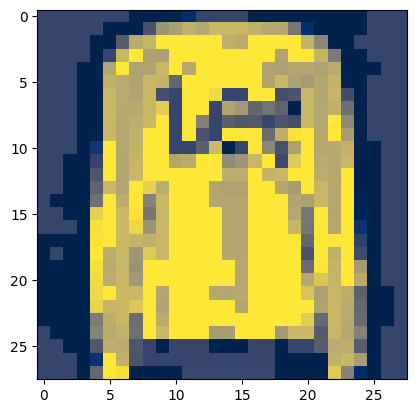

In [145]:
epsilon = 0.2  # define strenght of the attack
test_image_label = FMNIST_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(outputs.to(selected_device), test_image_label.to(selected_device))  # get loss value
attack_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
confused_image = Fast_Gradient_Sign_Method(test_image, epsilon, image_grad)

confused_image_np = confused_image.detach().to('cpu').numpy()
__ = plt.imshow(confused_image_np.reshape(28,28), cmap='cividis')

In [146]:
outputs = attack_model(confused_image.view((confused_image.shape[0], -1)))
print(f"The prediction of the model is {torch.argmax(outputs)}.")

The prediction of the model is 2.


The provided code defines a function that assesses the robustness of a given model against adversarial attacks.

In [147]:
def test_robustness(model, selected_device, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0

    for data, target in tqdm(test_loader):
        data, target = data.to(selected_device), target.to(selected_device)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28), cmap='cividis')
          plt.show()

        loss = functional.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        confused_data = Fast_Gradient_Sign_Method(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a confused sample:\n")
            plt.imshow(confused_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='cividis')
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                confused_data, __ = model.dbn_mnist.reconstruct(confused_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(confused_data[0].detach().to('cpu').numpy().reshape(28,28), cmap='cividis')
                plt.show()
                print_reconstruction = False

        # Re-classify the confused image
        output = model(confused_data)

        # Check for success
        # get the index of the max element in the output
        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

 Now we demonstrate the impact of an evasion attack on a neural network model.First the true label and the model's prediction before the attack are printed, and the original image, and then prints the model's prediction after applying the attack are displayed. The attack involves perturbing the input image using the Fast Gradient Sign Method. The visualizations aid in understanding how the model's prediction changes in response to the attack, highlighting the potential vulnerabilities of the model to adversarial perturbations.

In [148]:
confused_prediction = attack_model(confused_image.reshape(1, 28, 28).to(selected_device)).cpu().detach().max(axis=1).indices.numpy()[0]

True label: 4
Prediction before attack: tensor(2, device='cuda:0')


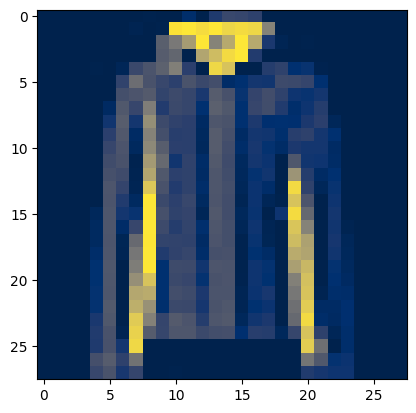

In [153]:
print('True label:', true_label)
print('Prediction before attack:', prediction)
__ = plt.imshow(original_image.cpu().numpy(), cmap='cividis')

Prediction after attack: 2


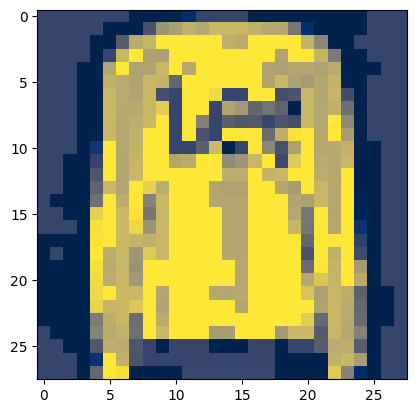

In [157]:
print('Prediction after attack:', confused_prediction)
__ = plt.imshow(confused_image.detach().cpu().numpy().reshape(28, 28), cmap='cividis')


The provided code evaluates the robustness of our models, against adversarial attacks. It utilizes the test_robustness function to assess the models' performance on a FashionMNIST test dataset. The models are subjected to an attack with a specified epsilon value, and their accuracy is measured both before and after the attack. The final accuracy results are obtained and stored. The evaluation provides insights into how well each model handles adversarial perturbations.

In [158]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.FashionMNIST('data/', train=False, download=False, transform=tv.transforms.Compose([tv.transforms.ToTensor(),
                                                                                                    tv.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=100, shuffle=True)

In [159]:
final_acc_ffnn = test_robustness(ffnn, selected_device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 67.52%



In [160]:
final_acc_dbn = test_robustness(dbn_with_readout.float(), selected_device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

  0%|          | 0/100 [00:00<?, ?it/s]


Epsilon: 0.1
Test Accuracy: 76.50%



  0%|          | 0/100 [00:00<?, ?it/s]


Here's the original sample:



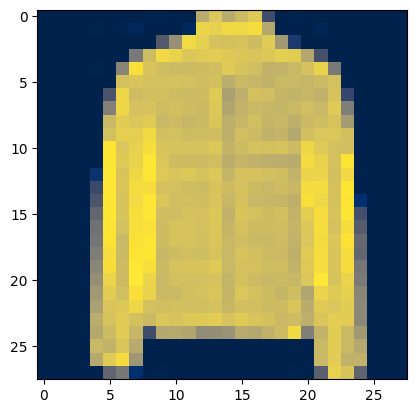


Here's a confused sample:



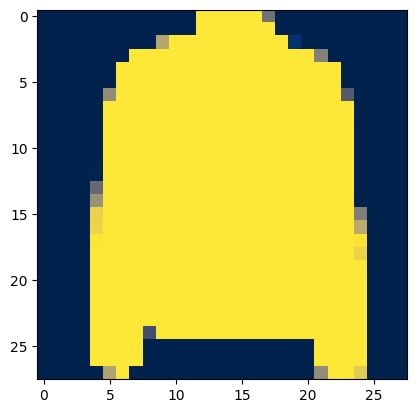


Here's what a 1-steps reconstructed sample looks like:



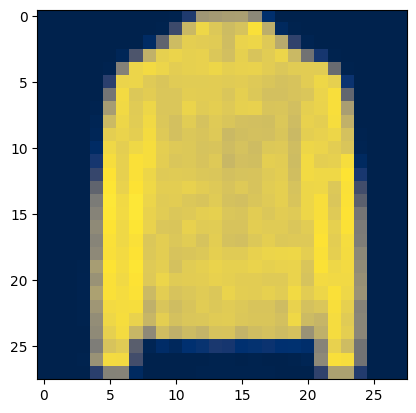


Epsilon: 0.1
Test Accuracy: 76.29%



In [161]:
final_acc = test_robustness(dbn_with_readout, selected_device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

The accuracy for dbn_with_readout is the highest among the models tested, indicating that this model is more robust to adversarial attacks with an epsilon value of 0.1 under the specified conditions.

 Now we test the effect of different strengths of adversarial attacks (controlled by varying epsilon values) on the accuracy of the models. The code below evaluates the robustness of different models (Feedforward Neural Network, Deep Belief Network with readout, and DBN with an additional reconstruction step) against adversarial attacks. It tests the models under varying strengths of attacks and compares their accuracies.

In [163]:
epsilons = [0, 0.05, 0.10, 0.15, 0.20, 0.25, 0.5, 1, 1.5, 2, 2.5 ]

def test_epsilons_effect(model, steps):
  accuracies = list()

  for eps in epsilons:
      accuracy = test_robustness(model, selected_device, test_loader, eps, num_steps=steps, verbose=False)
      accuracies.append(accuracy)

  return accuracies

In [164]:
%%capture
accuracies_ffnn = test_epsilons_effect(ffnn, steps=0)
accuracies_dbn1 = test_epsilons_effect(dbn_with_readout, steps=0)
accuracies_dbn2 = test_epsilons_effect(dbn_with_readout, steps=1)

 The resulting plot shows how the models' accuracy changes as the strength of adversarial attacks increases, providing insights into their robustness.

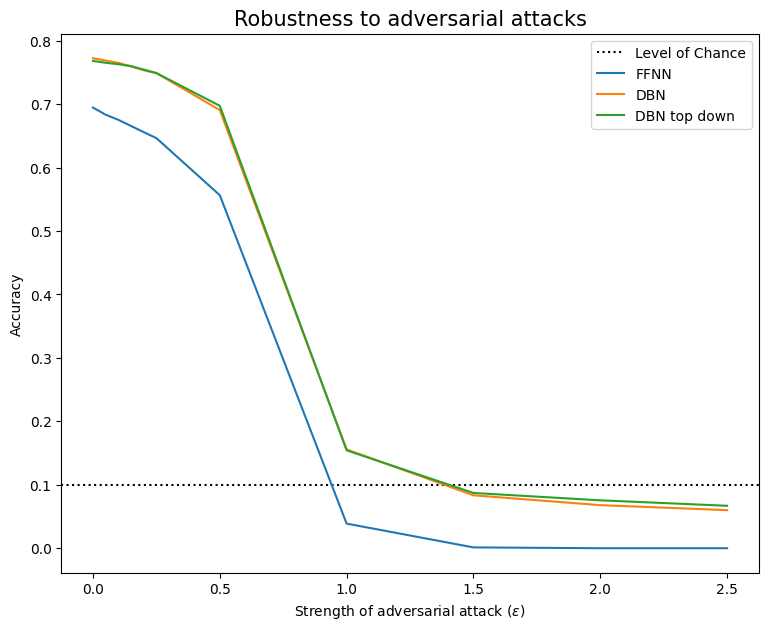

In [168]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='black', linestyle=':')
__ = ax.plot(epsilons, accuracies_ffnn)
__ = ax.plot(epsilons, accuracies_dbn1)
__ = ax.plot(epsilons, accuracies_dbn2)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Level of Chance", "FFNN", "DBN", "DBN top down"])

The findings from the plotted results indicate that the DBN system exhibits greater robustness to adversarial attacks compared to the FFNN model. The DBN system demonstrates a higher resistance to attacks across a range of epsilon values, showcasing its ability to maintain accuracy even under increased strength of adversarial perturbations. In contrast, the FFNN model appears more vulnerable to such attacks, with a noticeable decline in accuracy as the strength of the adversarial perturbations intensifies.